# IMPORT

In [17]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from pandas_profiling import ProfileReport
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from preprocess import preprocess
import plotly.express as px
import shutil
from sklearn_pandas import DataFrameMapper
import sqlite3 as sq
import os
%matplotlib inline

In [18]:
df = pd.read_csv('../data/profiles_revised.csv')
df.columns = df.columns.str.replace('\t', '') # needed?
origin = df.columns

In [19]:
if os.path.exists('./exploration/'):
    shutil.rmtree('./exploration/', ignore_errors=True)

In [20]:
def print_col_values(list, filename):
    with open(r'{}.txt'.format(filename), 'w') as fp:
        for element in list:
            fp.write("{}\n".format(element))

In [21]:
def df_distinct_values(df, folder):
    if not os.path.exists(folder):
        os.makedirs('./exploration/'+folder)
    for (index, colname) in enumerate(df.columns):
        #print(index, colname)
        distinc_values = df[colname].unique()
        print_col_values(list=distinc_values, filename='./exploration/{}/{}-{}-values'.format(folder, index, colname))

In [22]:
df_distinct_values(df=df, folder='origin')

In [23]:
profile = ProfileReport(df, title='Pandas Profilign Report')
profile.to_notebook_iframe()
profile.to_file('./exploration/pandas_profiling_data_report.html')

Render HTML: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 83.35it/s]


# CLEAN

In [24]:
#df = df[['age', 'body_type']]
df_clean = preprocess(df.columns, df)

In [25]:
# TODO: fix '\'
#df_distinct_values(df=df_clean, folder='cleaned')

# SAVE

In [26]:
df_clean.to_csv('./data/cleaned.csv')

# STANDARDIZE

In [27]:
df_clean.head()
sample = df_clean.iloc[:1]

In [28]:
continuous_cols = ['age', 'height']
categorical_cols = ['body_type', 'drinks', 'drugs', 'income', 'job', 'orientation', 'sex', 'smokes', 'status',
'diet','diet_modifier',
'education_status', 'education_institution',
'offspring_status', 'offspring_future',
'pets_cats', 'pets_dogs',
'religion_type', 'religion_modifier',
'sign', 'sign_modifier']
ethnities_cols = df_clean[df_clean.columns[pd.Series(df_clean.columns).str.startswith('ethnicities')]].columns
speaks_cols = df_clean[df_clean.columns[pd.Series(df_clean.columns).str.startswith('speaks')]].columns

In [29]:
# Example
mapper = DataFrameMapper([
  ('body_type', LabelEncoder()),
  (['age'], StandardScaler())],
  #[(categorical_col, LabelBinarizer()) for categorical_col in categorical_cols],
  df_out=True 
)
print(mapper)

DataFrameMapper(df_out=True, drop_cols=[],
                features=[('body_type', LabelEncoder()),
                          (['age'], StandardScaler())])


In [30]:
# Mapper for checking
mapper = DataFrameMapper([
  #('drinks', LabelEncoder()),
  (['age'], StandardScaler())] +
  [(categorical_col, LabelBinarizer()) for categorical_col in categorical_cols],
  df_out=True 
)
print(mapper)

DataFrameMapper(df_out=True, drop_cols=[],
                features=[(['age'], StandardScaler()),
                          ('body_type', LabelBinarizer()),
                          ('drinks', LabelBinarizer()),
                          ('drugs', LabelBinarizer()),
                          ('income', LabelBinarizer()),
                          ('job', LabelBinarizer()),
                          ('orientation', LabelBinarizer()),
                          ('sex', LabelBinarizer()),
                          ('smokes', LabelBinarizer()),
                          ('status', LabelBinarizer()),
                          ('diet', LabelBinari...
                          ('education_status', LabelBinarizer()),
                          ('education_institution', LabelBinarizer()),
                          ('offspring_status', LabelBinarizer()),
                          ('offspring_future', LabelBinarizer()),
                          ('pets_cats', LabelBinarizer()),
                   

In [31]:
# Real mapper
mapper = DataFrameMapper(
  [([continuous_col], StandardScaler()) for continuous_col in continuous_cols] +
  [(categorical_col, LabelEncoder()) for categorical_col in categorical_cols] +
  [(ethnities_col, LabelEncoder()) for ethnities_col in ethnities_cols] +
  [(speaks_col, LabelEncoder()) for speaks_col in speaks_cols],
  df_out=True 
)
mapper

DataFrameMapper(df_out=True, drop_cols=[],
                features=[(['age'], StandardScaler()),
                          (['height'], StandardScaler()),
                          ('body_type', LabelEncoder()),
                          ('drinks', LabelEncoder()), ('drugs', LabelEncoder()),
                          ('income', LabelEncoder()), ('job', LabelEncoder()),
                          ('orientation', LabelEncoder()),
                          ('sex', LabelEncoder()), ('smokes', LabelEncoder()),
                          ('status', LabelEncoder()), ('diet'...
                          ('sign', LabelEncoder()),
                          ('sign_modifier', LabelEncoder()),
                          ('ethnicities_indian', LabelEncoder()),
                          ('ethnicities_middle_eastern', LabelEncoder()),
                          ('ethnicities_hispanic_/_latin', LabelEncoder()),
                          ('ethnicities_black', LabelEncoder()),
                          ('ethnicities_white', LabelEncoder()),
                          ('ethnicities_asian', LabelEncoder()),
                          ('ethnicities_pacific_islander', LabelEncoder()), ...])

In [32]:
df_std = np.round(mapper.fit_transform(df_clean.copy()),2)

In [33]:
table_names = ['okcupid_clean', 'okcupid_std']
#table_path = './data/'+ table_name +'_db'

dfs = {
    "std_clean": df_clean,
    "dt_std": df_std,
}

with sq.connect('okcupid.sqlite') as db:
    df_clean.to_sql('okcupid_clean', db, if_exists='replace', index=True)
    df_std.to_sql('okcupid_std', db, if_exists='replace', index=True)


In [34]:
sample

age body_type   diet drinks      drugs  height   income  \
1   36   average  other  often  sometimes    70.0  80000.0   

                    job orientation sex  ... speaks_welsh  \
1  hospitality / travel    straight   m  ...            0   

  speaks_sign_language speaks_khmer speaks_cebuano speaks_afrikaans  \
1                    0            0              0                0   

  speaks_albanian  speaks_romanian  speaks_polish  speaks_turkish  \
1               0                0              0               0   

   speaks_finnish  
1               0  

[1 rows x 88 columns]

In [35]:
np.round(mapper.transform(sample), 2)

age  height  body_type  drinks  drugs  income  job  orientation  sex  \
1  0.49    0.33          2       2      2       6    8            2    1   

   smokes  ...  speaks_welsh  speaks_sign_language  speaks_khmer  \
1       0  ...             0                     0             0   

   speaks_cebuano  speaks_afrikaans  speaks_albanian  speaks_romanian  \
1               0                 0                0                0   

   speaks_polish  speaks_turkish  speaks_finnish  
1              0               0               0  

[1 rows x 88 columns]

In [36]:
# https://scikit-learn.org/stable/modules/preprocessing.html
# https://stackoverflow.com/questions/43554821/feature-preprocessing-of-both-continuous-and-categorical-variables-of-integer-t
# https://stackoverflow.com/questions/53152627/saving-standardscaler-model-for-use-on-new-datasets?noredirect=1&lq=1
# https://stackoverflow.com/questions/38780302/predicting-new-data-using-sklearn-after-standardizing-the-training-data

# Exploration

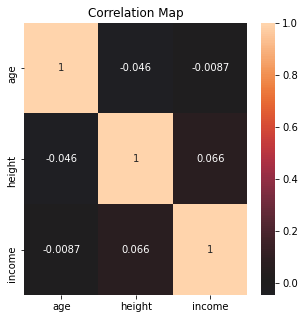

<Figure size 432x288 with 0 Axes>

In [37]:
plt.figure(figsize=(5,5))
sns.heatmap(df.corr(), center=0, annot=True)
plt.title('Correlation Map')
plt.show()
plt.savefig('./exploration/correlation-map.png')

In [38]:
#plt.figure(figsize=(5,5))
#sns.pairplot(data=df, hue='lables', palette='RdBu')
#plt.title('Correlation Map')
#plt.show()
#plt.savefig('./exploration/pairplot.png')

In [39]:
# TAKES FOREVER
for n_index, column in enumerate(df_std.columns):
    for m_index, column_iterator in enumerate(df_std.columns):
        pass
        #print(n_index, column, m_index, column_iterator)
        #plt.figure(figsize=(5, 5))
        #plt.scatter(df_std.iloc[:, n_index], df_std.iloc[:, m_index])
        #plt.xlabel(column)
        #plt.ylabel(column_iterator)
        #plt.title('Visualization of 2 features')

In [40]:
# TAKES FOREVER
# pd.plotting.scatter_matrix(df_std, alpha=0.2)


# PCA

In [41]:
pca = PCA()
pca.fit(df_std)
var_ratio = pca.explained_variance_ratio_

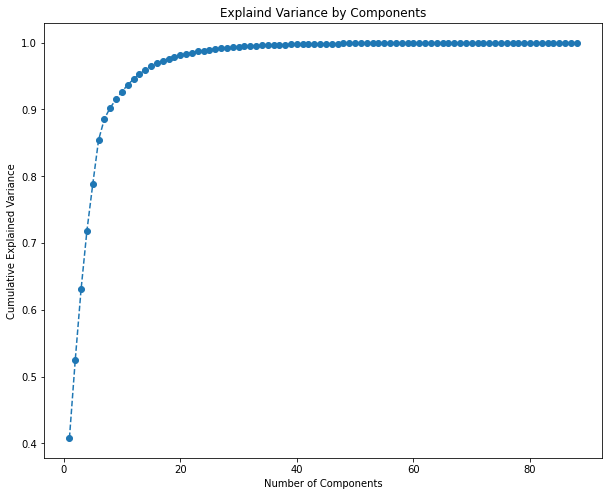

In [42]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(var_ratio)+1), var_ratio.cumsum(), marker='o', linestyle='--')
plt.title('Explaind Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
fig.savefig('./exploration/variance-by-principal-components.pdf')

In [43]:
PCA_COMPONENTS = 4

In [44]:
pca = PCA(n_components=PCA_COMPONENTS)
pca.fit(df_std)
scores_pca = pca.transform(df_std)
print(scores_pca)

[[ 1.87641346 -2.4757966   2.704807   -2.4524424 ]
 [10.09234004  2.37477898  3.37987402 -1.99797424]
 [-6.51778643 -2.00652081 -1.99861267 -0.2415023 ]
 ...
 [-5.57106598  4.02824219  4.5031385   0.20573236]
 [ 1.3895558  -1.39011495 -3.65556663 -3.6897442 ]
 [-0.12041779  4.72891946 -1.19558395  3.52545601]]


In [45]:
wcss = []
for i in range(1, 21):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=420)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

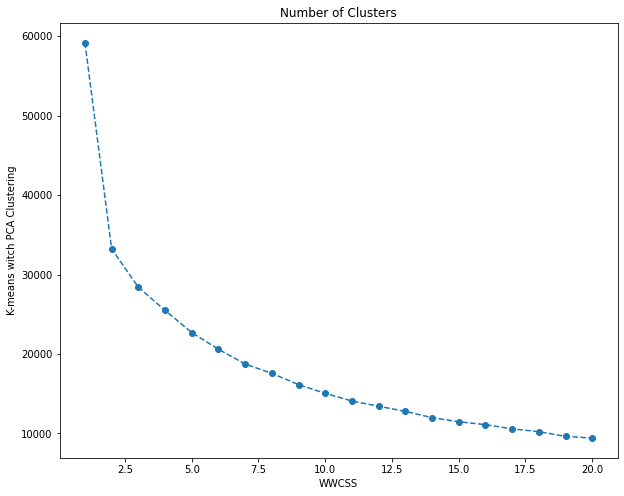

In [46]:
fig = plt.figure(figsize = (10,8))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.title('Number of Clusters')
plt.xlabel('WWCSS')
plt.ylabel('K-means witch PCA Clustering')
fig.savefig('./exploration/number-of-clusters.pdf')

In [47]:
OPTIMAL_N_CLUSTER = 4

In [48]:
kmeans_pca = KMeans(n_clusters=OPTIMAL_N_CLUSTER, init='k-means++', random_state=420)
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=420)

In [49]:
df_segm_pca_kmeans = pd.concat([df_std.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_segm_pca_kmeans.columns.values[-PCA_COMPONENTS:] = ['PComp 1', 'PComp 2', 'PComp 3', 'PComp 4']

df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [50]:
df_segm_pca_kmeans

age  height  body_type  drinks  drugs  income  job  orientation  sex  \
0    0.49    0.33          2       2      2       6    8            2    1   
1    0.29    1.12          1       4      2       8    0            2    1   
2   -0.62   -1.51          3       4      0       0   16            1    0   
3    0.49    2.69          4       1      0       3    6            2    1   
4   -0.21    0.07          2       4      0       4   10            2    1   
..    ...     ...        ...     ...    ...     ...  ...          ...  ...   
837 -0.21    0.86          1       4      0       7    6            2    1   
838 -0.42    0.86          9       4      2       3    1            2    1   
839  0.19    0.86          1       2      0       7   16            2    1   
840 -0.72   -2.29          9       2      2       1    8            2    0   
841  0.09   -0.19          4       4      2       3   10            2    1   

     smokes  ...  speaks_albanian  speaks_romanian  speaks_polish  \
0         0  ...                0                0              0   
1         0  ...                0                0              0   
2         0  ...                0                0              0   
3         0  ...                0                0              0   
4         0  ...                0                0              0   
..      ...  ...              ...              ...            ...   
837       0  ...                0                0              0   
838       0  ...                0                0              0   
839       0  ...                0                0              0   
840       4  ...                0                0              0   
841       0  ...                0                0              0   

     speaks_turkish  speaks_finnish    PComp 1   PComp 2   PComp 3   PComp 4  \
0                 0               0   1.876413 -2.475797  2.704807 -2.452442   
1                 0               0  10.092340  2.374779  3.379874 -1.997974   
2                 0               0  -6.517786 -2.006521 -1.998613 -0.241502   
3                 0               0   4.015999  5.000349 -0.926812 -3.429447   
4                 0               0  -0.426978 -3.657597  1.326256  1.634249   
..              ...             ...        ...       ...       ...       ...   
837               0               0   4.221600  5.011642  2.939411  1.483792   
838               0               0   9.040226  1.797837 -1.873417 -4.000642   
839               0               0  -5.571066  4.028242  4.503139  0.205732   
840               0               0   1.389556 -1.390115 -3.655567 -3.689744   
841               0               0  -0.120418  4.728919 -1.195584  3.525456   

     Segment K-means PCA  
0                      1  
1                      3  
2                      0  
3                      2  
4                      1  
..                   ...  
837                    3  
838                    2  
839                    0  
840                    1  
841                    1  

[842 rows x 93 columns]

In [51]:
df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0: 'first',
    1: 'second',
    2: 'third',
    3: 'fourth'
})

In [52]:
df_segm_pca_kmeans.head()

age  height  body_type  drinks  drugs  income  job  orientation  sex  \
0  0.49    0.33          2       2      2       6    8            2    1   
1  0.29    1.12          1       4      2       8    0            2    1   
2 -0.62   -1.51          3       4      0       0   16            1    0   
3  0.49    2.69          4       1      0       3    6            2    1   
4 -0.21    0.07          2       4      0       4   10            2    1   

   smokes  ...  speaks_romanian  speaks_polish  speaks_turkish  \
0       0  ...                0              0               0   
1       0  ...                0              0               0   
2       0  ...                0              0               0   
3       0  ...                0              0               0   
4       0  ...                0              0               0   

   speaks_finnish    PComp 1   PComp 2   PComp 3   PComp 4  \
0               0   1.876413 -2.475797  2.704807 -2.452442   
1               0  10.092340  2.374779  3.379874 -1.997974   
2               0  -6.517786 -2.006521 -1.998613 -0.241502   
3               0   4.015999  5.000349 -0.926812 -3.429447   
4               0  -0.426978 -3.657597  1.326256  1.634249   

   Segment K-means PCA  Segment  
0                    1   second  
1                    3   fourth  
2                    0    first  
3                    2    third  
4                    1   second  

[5 rows x 94 columns]

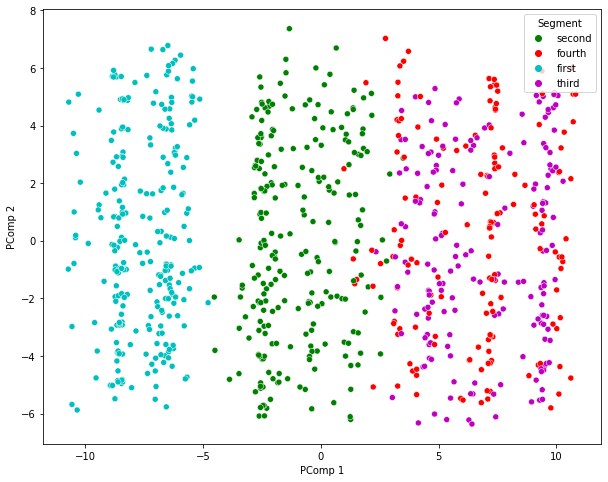

In [53]:
x_axis = df_segm_pca_kmeans['PComp 1']
y_axis = df_segm_pca_kmeans['PComp 2']
plt.figure(figsize=(10,8))
sns.scatterplot(x=x_axis, y=y_axis, hue = df_segm_pca_kmeans['Segment'], palette=['g', 'r', 'c', 'm'])
plt.show()

In [54]:
df_cluster = df_segm_pca_kmeans.iloc[:,-6:] # 4 components + hue + cat
df_cluster.head

<bound method NDFrame.head of        PComp 1   PComp 2   PComp 3   PComp 4  Segment K-means PCA Segment
0     1.876413 -2.475797  2.704807 -2.452442                    1  second
1    10.092340  2.374779  3.379874 -1.997974                    3  fourth
2    -6.517786 -2.006521 -1.998613 -0.241502                    0   first
3     4.015999  5.000349 -0.926812 -3.429447                    2   third
4    -0.426978 -3.657597  1.326256  1.634249                    1  second
..         ...       ...       ...       ...                  ...     ...
837   4.221600  5.011642  2.939411  1.483792                    3  fourth
838   9.040226  1.797837 -1.873417 -4.000642                    2   third
839  -5.571066  4.028242  4.503139  0.205732                    0   first
840   1.389556 -1.390115 -3.655567 -3.689744                    1  second
841  -0.120418  4.728919 -1.195584  3.525456                    1  second

[842 rows x 6 columns]>

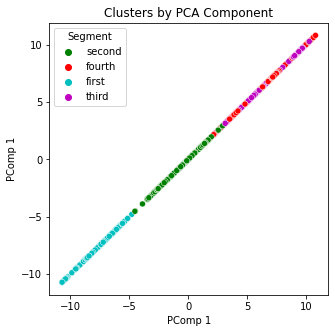

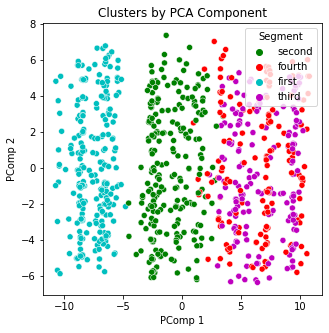

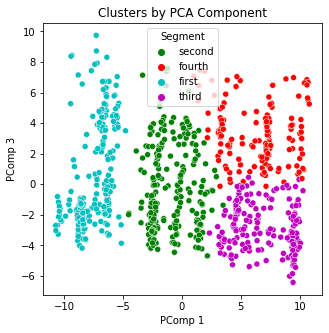

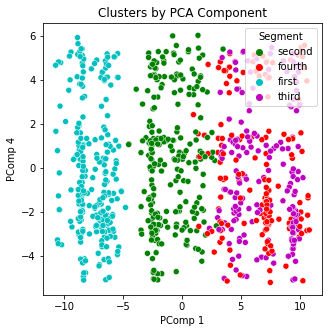

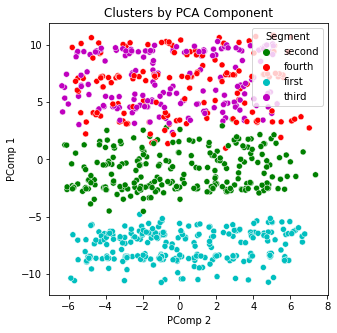

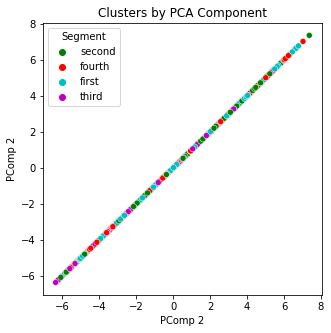

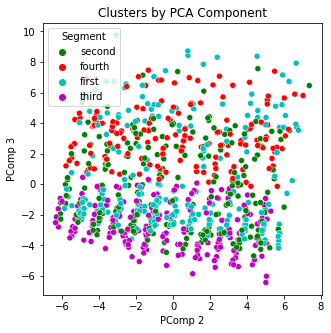

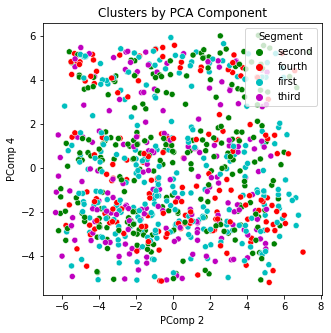

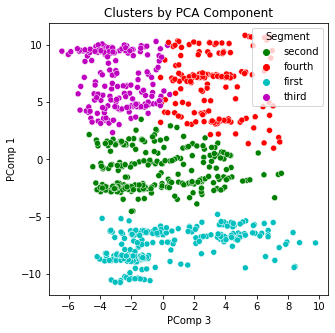

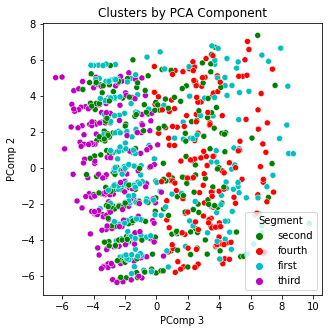

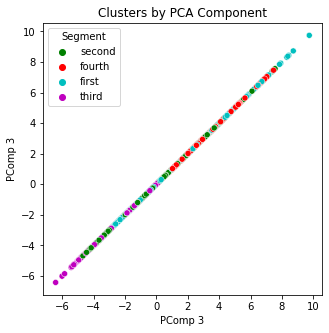

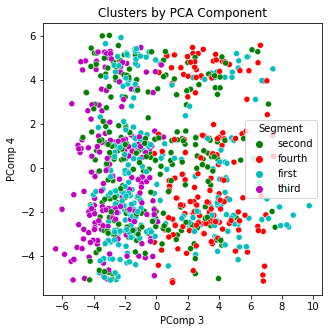

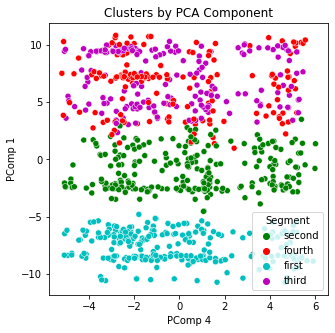

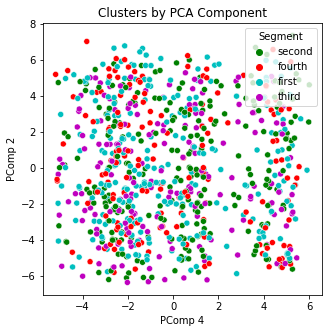

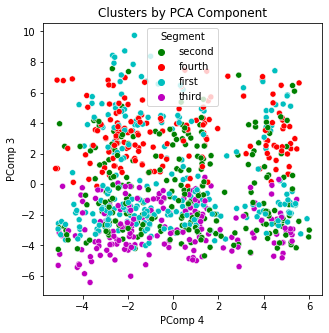

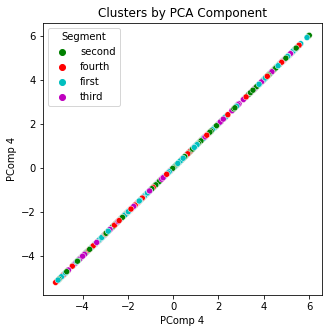

In [55]:
if not os.path.exists('./exploration/PCA'):
        os.makedirs('./exploration/PCA')

for n_index, column in enumerate(df_cluster.columns[:PCA_COMPONENTS]):
    for m_index, column_iterator in enumerate(df_cluster.columns[:PCA_COMPONENTS]):
        #print(n_index, column, m_index, column_iterator)
        fig = plt.figure(figsize=(5, 5))
        sns.scatterplot(x=df_cluster[column], y=df_cluster[column_iterator], hue = df_segm_pca_kmeans['Segment'], palette=['g', 'r', 'c', 'm'])
        plt.xlabel(column)
        plt.ylabel(column_iterator)
        plt.title('Clusters by PCA Component')
        fig.savefig('./exploration/PCA/PCA {} vs {}.pdf'.format(column, column_iterator)) 
        #plt.show()

In [56]:
fig = px.scatter(df_cluster, x="PComp 1", y="PComp 2", color='Segment', text=df_cluster.index)
fig.show()